## Setup


In [ ]:
#@title default imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from google.colab import drive
import torch

%matplotlib inline

In [ ]:
#@title mount google drive {display-mode: "form"}
drive.mount("/gdrive")

Mounted at /gdrive


In [ ]:
#@title dataset folder
gdrive_dir = "/gdrive/MyDrive"
pibic_dir = os.path.join(gdrive_dir, "PIBIC")
ucmerced_dir = os.path.join(pibic_dir, "UCMerced/UCMerced_LandUse/Images")
!ls $ucmerced_dir

agricultural	 buildings	   freeway	 mediumresidential  river	       tenniscourt
airplane	 chaparral	   golfcourse	 mobilehomepark     runway
baseballdiamond  denseresidential  harbor	 overpass	    sparseresidential
beach		 forest		   intersection  parkinglot	    storagetanks


In [ ]:
#@title detecting backend device
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"Using {device} as default device")

Using cuda as default device


In [ ]:
#@title generating datasets
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from datetime import datetime

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = ImageFolder(root=ucmerced_dir)

# Splits data for training & validation sets
validation_split = 0.3
n_data = len(dataset)
n_validation = int(validation_split * n_data)
n_train = n_data - n_validation

# Create datasets for training & validation
train_set, validation_set = random_split(dataset, [n_train, n_validation], generator=torch.Generator(device=device))

class CustomTransformDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        X, y = self.subset[index]
        if self.transform:
            X = self.transform(X)
        return X, y

    def __len__(self):
        return len(self.subset)

def collate_fn(batch_data):
    print(batch_data[0])
    return batch_data

# Create data loaders for our datasets; shuffle for training, not for validation
batch_size = 64
custom_train_set = CustomTransformDataset(train_set, transform_train)
custom_validation_set = CustomTransformDataset(validation_set, transform_test)
train_dataloader = DataLoader(custom_train_set, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))
validation_dataloader = DataLoader(custom_validation_set, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))

for data in train_dataloader:
    print(data)
    break

# Class labels
classes = dataset.classes
n_classes = len(classes)

# Report split sizes
print(f"Training set has {len(train_set)} instances")
print(f"Validation set has {len(validation_set)} instances")

[tensor([[[[-0.0972, -0.2513, -0.4568,  ...,  0.2796,  0.1426,  0.0398],
          [-0.2513, -0.3369, -0.4397,  ...,  0.2796,  0.0398, -0.1486],
          [-0.3541, -0.3541, -0.3883,  ...,  0.2282, -0.0629, -0.3027],
          ...,
          [ 1.5125,  1.4954,  1.4612,  ...,  0.3138,  0.1939,  0.0912],
          [ 1.2899,  1.2899,  1.2728,  ...,  0.3309,  0.2111,  0.1083],
          [ 1.0331,  1.0159,  1.0159,  ...,  0.3309,  0.2111,  0.1254]],

         [[ 0.3978,  0.2227,  0.0126,  ...,  0.5728,  0.5028,  0.4503],
          [ 0.3102,  0.2052,  0.0826,  ...,  0.5728,  0.4328,  0.3452],
          [ 0.1877,  0.1527,  0.1001,  ...,  0.5378,  0.3627,  0.2227],
          ...,
          [ 1.6057,  1.5882,  1.5357,  ...,  0.8179,  0.7304,  0.6779],
          [ 1.3957,  1.3782,  1.3606,  ...,  0.8354,  0.7304,  0.6779],
          [ 1.1681,  1.1331,  1.1155,  ...,  0.8529,  0.7304,  0.6604]],

         [[ 0.6356,  0.5136,  0.3568,  ...,  0.6879,  0.6182,  0.5834],
          [ 0.5485,  0.4439, 

['baseballdiamond', 'sparseresidential', 'buildings', 'runway', 'harbor', 'river', 'freeway', 'forest', 'harbor', 'tenniscourt', 'agricultural', 'sparseresidential', 'buildings', 'chaparral', 'harbor', 'beach', 'overpass', 'beach', 'parkinglot', 'storagetanks', 'golfcourse', 'golfcourse', 'golfcourse', 'river', 'sparseresidential', 'airplane', 'sparseresidential', 'river', 'airplane', 'agricultural', 'baseballdiamond', 'mobilehomepark', 'golfcourse', 'river', 'parkinglot', 'chaparral', 'overpass', 'denseresidential', 'sparseresidential', 'runway', 'intersection', 'buildings', 'storagetanks', 'runway', 'mediumresidential', 'runway', 'tenniscourt', 'freeway', 'airplane', 'intersection', 'denseresidential', 'mediumresidential', 'storagetanks', 'storagetanks', 'buildings', 'harbor', 'forest', 'freeway', 'storagetanks', 'freeway', 'sparseresidential', 'agricultural', 'runway', 'agricultural']


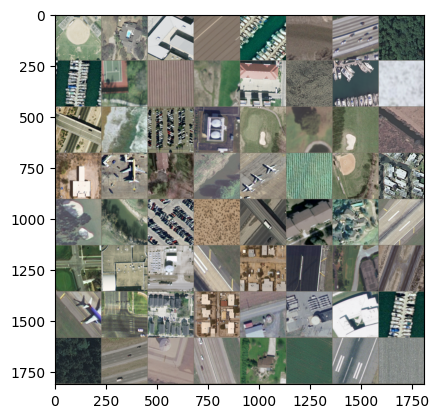

In [ ]:
#@title Datasets sanity check {display-mode: "form"}
def matplotlib_imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

iterator = iter(train_dataloader)
images, labels = next(iterator)

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print([classes[labels[i]] for i in range(batch_size)])
plt.show()

In [ ]:
#@title tensorboard
from torch.utils.tensorboard import SummaryWriter

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f"runs/ucmerced_trainer_{timestamp}")

## Model

In [ ]:
#@title calling model
import torch.nn as nn
from torchvision import models
import torchinfo

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model.to(device)
torchinfo.summary(model.cuda(), [(3, 224, 224)]*3, batch_dim=batch_size,
                  col_names=(“input_size”, “output_size”, “num_params”, “kernel_size”, “mult_adds”), verbose=0)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 112, 112]           9,408
       BatchNorm2d-2         [64, 64, 112, 112]             128
              ReLU-3         [64, 64, 112, 112]               0
         MaxPool2d-4           [64, 64, 56, 56]               0
            Conv2d-5           [64, 64, 56, 56]          36,864
       BatchNorm2d-6           [64, 64, 56, 56]             128
              ReLU-7           [64, 64, 56, 56]               0
            Conv2d-8           [64, 64, 56, 56]          36,864
       BatchNorm2d-9           [64, 64, 56, 56]             128
             ReLU-10           [64, 64, 56, 56]               0
       BasicBlock-11           [64, 64, 56, 56]               0
           Conv2d-12           [64, 64, 56, 56]          36,864
      BatchNorm2d-13           [64, 64, 56, 56]             128
             ReLU-14           [64, 64,

In [ ]:
#@title Loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#@title Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
#@title Traininig loop
from sklearn.metrics import accuracy_score

def train_one_epoch(print_all = False, batch_i = 10):
    running_loss = 0.
    avg_loss = 0.
    predictions = []
    targets = []

    for i, (inps, lbls) in enumerate(train_dataloader):
        inputs = inps.to(device)
        labels = lbls.to(device)

        optimizer.zero_grad()

        if torch.cuda.is_available():
            outputs = nn.parallel.data_parallel(model, inputs)
        else:
            outputs = model(inputs)

        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1);
        predictions.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())
        if (i % batch_i == (batch_i - 1)) and not print_all:
            print(f"batch {i + 1} loss: {running_loss / batch_i}")
            running_loss = 0.
        elif print_all:
            print(f"batch {i + 1} loss {loss.item()}")

    return (avg_loss / (i + 1), accuracy_score(targets, predictions))

def validate():
    avg_vloss = 0.
    predictions = []
    targets = []

    with torch.no_grad():
        for i, (inps, lbls) in enumerate(validation_dataloader):
            vinputs = inps.to(device)
            vlabels = lbls.to(device)
            if torch.cuda.is_available():
                voutputs = nn.parallel.data_parallel(model, vinputs)
            else:
                voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            avg_vloss += vloss.item()
            _, predicted = torch.max(voutputs, 1);
            predictions.extend(predicted.cpu().numpy())
            targets.extend(vlabels.cpu().numpy())

    return (avg_vloss / (i + 1), accuracy_score(targets, predictions))

loss_history_train = []
acc_history_train = []
loss_history_val = []
acc_history_val = []
def train(n_epochs):
    best_vloss = 1_000_000
    for epoch in range(n_epochs):
        print(f"========================================================\nEPOCH {epoch + 1}")

        model.train()
        avg_loss, acc_train = train_one_epoch()
        loss_history_train.append(avg_loss)
        acc_history_train.append(acc_train)
        model.eval()
        avg_vloss, acc_valid = validate()
        loss_history_val.append(avg_vloss)
        acc_history_val.append(acc_valid)
        print(f"train accuracy {acc_train * 100:.4f}% validation accuracy {acc_valid * 100:.4f}%")
        writer.add_scalars("training loss | validation loss",
                           {"train" : avg_loss, "valid": avg_vloss},
                           epoch + 1)
        writer.flush()

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_dir = os.path.join(pibic_dir, f"runs/UCMerced/last.pth")
            torch.save(model.state_dict(), model_dir)

        scheduler.step()
    print(f"\nTraining finished\n\tFinal model accurary: train {acc_train * 100:.4f} valid {acc_valid * 100:.4f}")

train(110)

In [ ]:
#@title model refresh
torch.cuda.empty_cache()

In [ ]:
#@title visualising model improvment
plt.figure(figsize=(16,9))

plt.subplot(2, 2, 1)
plt.plot(acc_history_train)
plt.xlabel('epochs')
plt.ylabel('accurary')
plt.title('train accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss_history_train)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train loss')

plt.subplot(2, 2, 3)
plt.plot(acc_history_val)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('validation accuracy')

plt.subplot(2, 2, 4)
plt.plot(loss_history_val)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('validation loss')
plt.show()

## Testing

In [ ]:
#@title loading last run model
import torch.nn as nn
from torchvision import models
from torchsummary import summary

model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, n_classes)
model.to(device)

model.load_state_dict(torch.load(os.path.join(pibic_dir, "runs/UCMerced/last.pth"), map_location=torch.device(device)))

<All keys matched successfully>

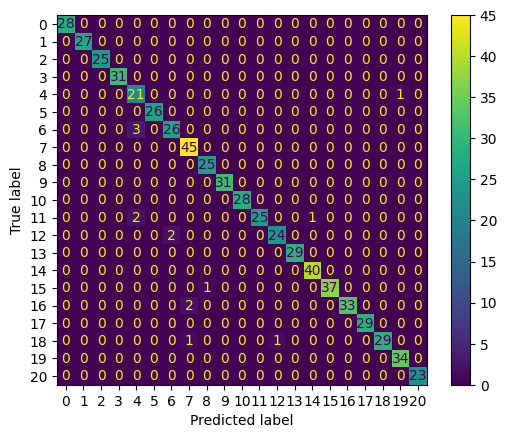

In [ ]:
#@title confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def make_confusion_matrix():
    true_labels = []
    predicted_labels = []
    model.eval()

    with torch.no_grad():
        for i, (inps, lbls) in enumerate(validation_dataloader):
            vinputs = inps.to(device)
            vlabels = lbls.to(device)
            if torch.cuda.is_available():
                voutputs = nn.parallel.data_parallel(model, vinputs)
            else:
                voutputs = model(vinputs)
            _, predicted = torch.max(voutputs, 1)
            true_labels.extend(vlabels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    return confusion_matrix(true_labels, predicted_labels)

cm = make_confusion_matrix()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(n_classes))
disp.plot()
plt.show()

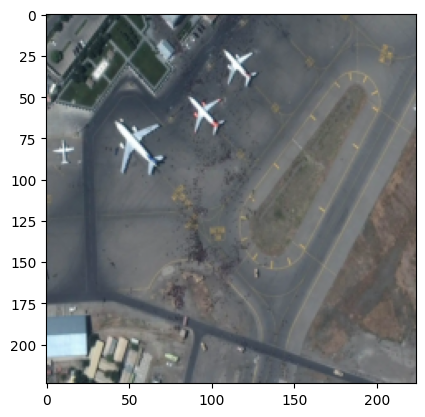

model predicted airplane


In [ ]:
#@title predicting an example
from matplotlib.colors import Image

img0 = Image.open(os.path.join(pibic_dir, "test/test00.webp"))
input_img = transform_test(img0)
matplotlib_imshow(input_img)

input_img = input_img.unsqueeze(0)
input_img = input_img.to(device)
model.eval()
output = model(input_img)
predicted_class = torch.argmax(output, dim=1).item()
print(f"model predicted {classes[predicted_class]}")
plt.show()